In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans as kmeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import seaborn as sns
import math
import os

excelpath = 'excel_gaming_data'
ddict = {} # Created A dataframe dictionary to modify each dictionary iteratively
for filename in os.listdir(excelpath): # Iterates through each excel file
    f = os.path.join(excelpath, filename)
    # checking if it is a file
    if os.path.isfile(f) & ~filename.startswith('.'):
        ddict[filename[-6:-4]] = pd.read_excel(excelpath + '/' + filename) # sets the value of each dictionary
        
        for idx, val in enumerate(ddict[filename[-6:-4]].iloc[0,:]): # Iterates through each column of the excel spread sheet in question
            if idx > 1:
                if idx > 7:
                    ddict[filename[-6:-4]].columns.values[idx] = ddict[filename[-6:-4]].iloc[0,idx] + ' 20' + str(filename[-6:-4]) # Changes the column name using the next year and the month. The next year is used if past December, which corresponds to an index of 7, ad
                else:
                    ddict[filename[-6:-4]].columns.values[idx] = ddict[filename[-6:-4]].iloc[0,idx] + ' 20' + str(filename[-9:-7]) # Changes the column name using the first year specified and the month
        if filename[-6:-4] != '11': # Removes the first 2 columns of the excel spread sheet, except if it is the starting year spread sheet
            ddict[filename[-6:-4]] = ddict[filename[-6:-4]].drop(columns=ddict[filename[-6:-4]].columns[0])
            ddict[filename[-6:-4]] = ddict[filename[-6:-4]].drop(columns=ddict[filename[-6:-4]].columns[0])
            
gamedf = ddict['11'] # initializes the dataframe for our game data
for ind in range(12,21): # Concatenates all dictionary values into one pandas dataframe
    gamedf = pd.concat([gamedf,ddict[str(ind)]],axis=1)

# Changed some column names:
gamedf.columns.values[0] = 'Location' 
gamedf.columns.values[1] = 'Attributes'
gamedf = gamedf.drop(0) # Removes the first row 
gamedf = gamedf.iloc[0:429,:] # We had extra noisy data, which I just removed, since it did not correspond to a date.
# I don't know why this is, hopefully it didn't correspond to other data, but I didn't see any missing data.
gamedf_T=gamedf.T
gamedf_T.columns = gamedf_T.iloc[1]
gamedf_T=gamedf_T.drop(gamedf_T.index[[1]])


colval = gamedf_T.columns[0] # The first column header device

# Renamed the column headers so each attribute is unique to a device. This will allow us to reference these headers.
for ind in range(1,len(gamedf_T.columns)):
    if pd.isna(gamedf_T.columns[ind - 1]):
        colval = gamedf_T.columns[ind]

    if (not pd.isna(gamedf_T.columns[ind - 1])) and (not pd.isna(gamedf_T.columns[ind])):
        gamedf_T.columns.values[ind] = str(colval) + ' ' + str(gamedf_T.columns[ind])

for ind in range(1,len(gamedf_T.columns)):
    if pd.isna(gamedf_T.columns[ind]):
        gamedf_T.columns.values[ind] = 'trash'

gamedf_T.drop(['trash'], axis = 1, inplace = True)

# Filled in missing values using the mean of the corresponding column
for col in gamedf_T.columns:
    avg = gamedf_T[col].mean()
    gamedf_T[col].fillna(avg, inplace = True)

filt = (gamedf_T == 'Statewide').any()
state = gamedf_T.loc[: , filt].drop(['Location'])

filt = (gamedf_T == 'Cripple Creek').any()
cripple = gamedf_T.loc[: , filt].drop(['Location'])

filt = (gamedf_T == 'Black Hawk').any()
black = gamedf_T.loc[: , filt].drop(['Location'])

filt = (gamedf_T == 'Central City').any()
central = gamedf_T.loc[: , filt].drop(['Location'])

#resets the index so we can work this the month year column
state.reset_index(inplace=True)
state[['month','year']] = state.iloc[:,0].str.split(expand=True)
#state = state.set_index(['year', 'month'])

cripple.reset_index(inplace=True)
cripple[['month','year']] = cripple.iloc[:,0].str.split(expand=True)

black.reset_index(inplace=True)
black[['month','year']] = black.iloc[:,0].str.split(expand=True)

central.reset_index(inplace=True)
central[['month','year']] = central.iloc[:,0].str.split(expand=True)

#create a df containing only the yearly total values
monchoose = ['JULY', 'AUGUST', 'SEPTEMBER', 'OCTOBER', 'NOVEMBER', 'DECEMBER', 'JANUARY', 'FEBRUARY', 'MARCH', 'APRIL', 'MAY', 'JUNE']

state_totals= state.loc[state['month'].isin(monchoose)]

cripple_totals= cripple.loc[cripple['month'].isin(monchoose)]

black_totals= black.loc[black['month'].isin(monchoose)]

central_totals= central.loc[central['month'].isin(monchoose)]


/tmp/ipykernel_139/2013982651.py:63: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  avg = gamedf_T[col].mean()


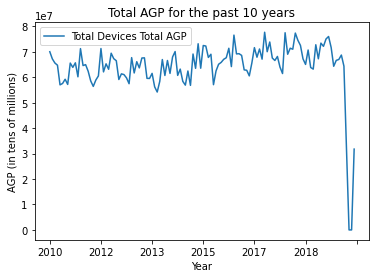

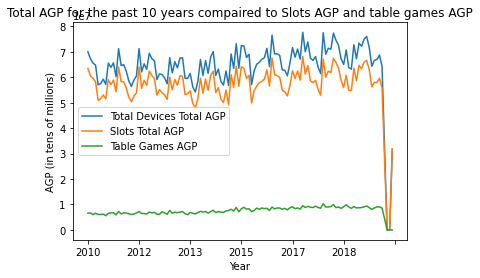

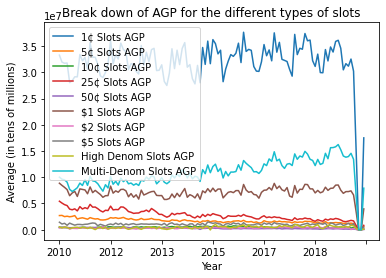

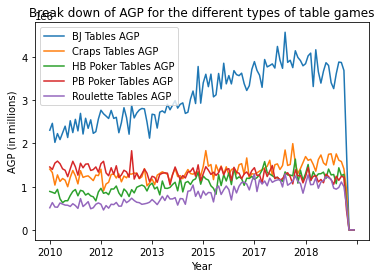

In [2]:
#plot 1
ax = plt.gca()

state_totals.plot(kind='line',x='year',y='Total Devices Total AGP',ax=ax)

plt.title("Total AGP for the past 10 years")
plt.xlabel("Year")
plt.ylabel("AGP (in tens of millions)")
plt.show()


#plot 2
ax = plt.gca()

state_totals.plot(kind='line',x='year',y='Total Devices Total AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='Slots Total AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='Table Games AGP',ax=ax)



plt.title("Total AGP for the past 10 years compaired to Slots AGP and table games AGP")
plt.xlabel("Year")
plt.ylabel("AGP (in tens of millions)")
plt.show()


#plot 3
ax = plt.gca()

state_totals.plot(kind='line',x='year',y='1¢ Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='5¢ Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='10¢ Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='25¢ Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='50¢ Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='$1 Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='$2 Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='$5 Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='High Denom Slots AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='Multi-Denom Slots AGP',ax=ax)
#state.plot(kind='line',x='name',y='num_pets', color='red', ax=ax)

plt.title("Break down of AGP for the different types of slots")
plt.xlabel("Year")
plt.ylabel("Average (in tens of millions)")
plt.show()

#plot 4
ax = plt.gca()

state_totals.plot(kind='line',x='year',y='BJ Tables AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='Craps Tables AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='HB Poker Tables AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='PB Poker Tables AGP',ax=ax)
state_totals.plot(kind='line',x='year',y='Roulette Tables AGP',ax=ax)
#state.plot(kind='line',x='name',y='num_pets', color='red', ax=ax)

plt.title("Break down of AGP for the different types of table games")
plt.xlabel("Year")
plt.ylabel("AGP (in millions)")
plt.show()


state_totals.to_csv('state_totals.csv')
colors = ['r','g','b']
#plt.scatter(state.iloc[:,0],np.zeros(len(state.iloc[:,0])), color='r')
#plt.scatter(cripple.iloc[:,0],np.zeros(len(cripple.iloc[:,0])), color='g')
#plt.scatter(black.iloc[:,0],np.zeros(len(black.iloc[:,0])), color='b')

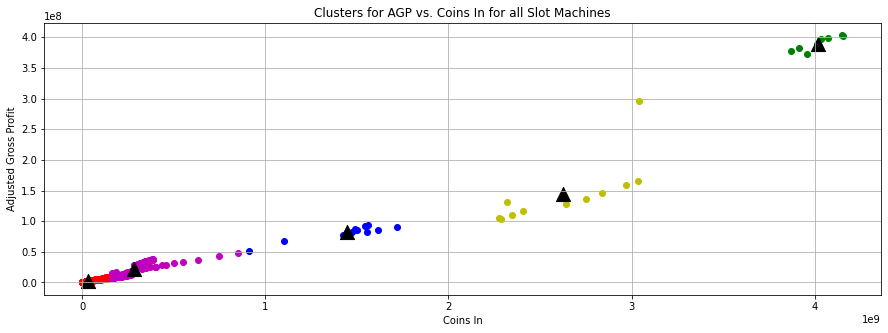

In [3]:
allsltagp = pd.concat([state.loc[:,'1¢ Slots AGP'],state.loc[:,'5¢ Slots AGP'],state.loc[:,'10¢ Slots AGP'],state.loc[:,'25¢ Slots AGP'],state.loc[:,'50¢ Slots AGP'],state.loc[:,'$1 Slots AGP'],state.loc[:,'$2 Slots AGP'],state.loc[:,'$5 Slots AGP'],state.loc[:,'High Denom Slots AGP'],state.loc[:,'Multi-Denom Slots AGP']])
allsltcoin = pd.concat([state.loc[:,'1¢ Slots Coins In'],state.loc[:,'5¢ Slots Coins In'],state.loc[:,'10¢ Slots Coins In'],state.loc[:,'25¢ Slots Coins In'],state.loc[:,'50¢ Slots Coins In'],state.loc[:,'$1 Slots Coins In'],state.loc[:,'$2 Slots Coins In'],state.loc[:,'$5 Slots Coins In'],state.loc[:,'High Denom Slots Coins In'],state.loc[:,'Multi-Denom Slots Coins In']])
plt.rcParams['figure.figsize'] = [15,5]
allsltagp = allsltagp.to_numpy()
allsltcoin = allsltcoin.to_numpy()

'''
plt.scatter(state.loc[:,'Slots Total Coins In'],state.loc[:,'Slots Total AGP'],color='r')
plt.scatter(cripple.loc[:,'Slots Total Coins In'],cripple.loc[:,'Slots Total AGP'],color='g')
plt.scatter(black.loc[:,'Slots Total Coins In'],black.loc[:,'Slots Total AGP'],color='b')
plt.scatter(central.loc[:,'Slots Total Coins In'],central.loc[:,'Slots Total AGP'],color='y')
'''

points = np.vstack((allsltcoin,allsltagp)).T
kmeansmodel = kmeans(n_clusters=5)
values = kmeansmodel.fit_predict(points)
centind0 = np.where(values[:] == 0)[0]
centind1 = np.where(values[:] == 1)[0]
centind2 = np.where(values[:] == 2)[0]
centind3 = np.where(values[:] == 3)[0]
centind4 = np.where(values[:] == 4)[0]
centroids = kmeansmodel.cluster_centers_

ax = plt.gca()
plt.grid()
#plt.scatter(allsltcoin,allsltagp,color='r')

plt.scatter(allsltcoin[centind0],allsltagp[centind0],color='r')
plt.scatter(allsltcoin[centind1],allsltagp[centind1],color='g')
plt.scatter(allsltcoin[centind2],allsltagp[centind2],color='b')
plt.scatter(allsltcoin[centind3],allsltagp[centind3],color='m')
plt.scatter(allsltcoin[centind4],allsltagp[centind4],color='y')
plt.scatter(centroids[:,0],centroids[:,1],color='k', marker='^', s = 200)
plt.xlabel('Coins In')
plt.ylabel('Adjusted Gross Profit')
plt.title('Clusters for AGP vs. Coins In for all Slot Machines')
'''
ax = plt.gca()
plt.grid()
plt.scatter(state.loc[:,'1¢ Slots Coins In'],state.loc[:,'1¢ Slots AGP'],color='b',label='1¢ Slots')
plt.scatter(state.loc[:,'5¢ Slots Coins In'],state.loc[:,'5¢ Slots AGP'],color='g',label='5¢ Slots')
plt.scatter(state.loc[:,'25¢ Slots Coins In'],state.loc[:,'25¢ Slots AGP'],color='r',label='25¢ Slots')
plt.scatter(state.loc[:,'$1 Slots Coins In'],state.loc[:,'$1 Slots AGP'],color='c',label='$1 Slots')
plt.scatter(state.loc[:,'$5 Slots Coins In'],state.loc[:,'$5 Slots AGP'],color='m',label='$5 Slots')
plt.scatter(state.loc[:,'High Denom Slots Coins In'],state.loc[:,'High Denom Slots AGP'],color='y',label='High Denom Slots')
plt.scatter(state.loc[:,'Multi-Denom Slots Coins In'],state.loc[:,'Multi-Denom Slots AGP'],color='k',label='Multi-Denom Slots')
plt.xlabel('Coins In')
plt.ylabel('AGP')
plt.title('AGP vs. Coins In for all Slot Machines')
plt.legend()
'''
plt.savefig('plt8.png')

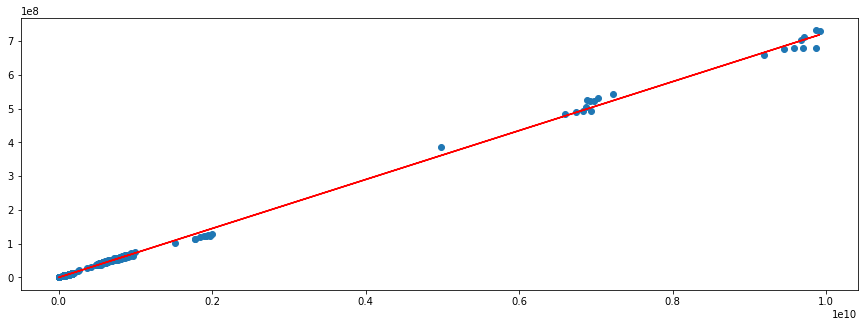

In [4]:
slotcoin = pd.concat([state.loc[:,'Slots Total Coins In'],cripple.loc[:,'Slots Total Coins In'],black.loc[:,'Slots Total Coins In'],central.loc[:,'Slots Total Coins In']],axis=0)
slotagp = pd.concat([state.loc[:,'Slots Total AGP'],cripple.loc[:,'Slots Total AGP'],black.loc[:,'Slots Total AGP'],central.loc[:,'Slots Total AGP']],axis=0)
slotagp = slotagp.to_numpy()
slotcoin = slotcoin.to_numpy()

xdata = slotcoin.reshape(-1,1)
ydata = slotagp.reshape(-1,1)
xdata_train, xdata_test, ydata_train, ydata_test = train_test_split(xdata, ydata, test_size=0.2)
linreg = LinearRegression()
linreg.fit(xdata_train, ydata_train)
ydata_pred = linreg.predict(xdata_test)
inter = linreg.intercept_
slope = linreg.coef_
calcy = xdata*slope + inter
ax = plt.gca()
plt.plot(xdata,calcy,'r')
plt.scatter(slotcoin,slotagp)

Attributes           index Slots Total Slots Total Coins In Slots Total AGP  \
0                JULY 2010       15224         924881940.34     63485300.52   
1              AUGUST 2010       15182         900224418.95      60548129.6   
2           SEPTEMBER 2010       15189         859887596.89     59638919.56   
3             OCTOBER 2010       15067         859014005.02     58207468.91   
4            NOVEMBER 2010       14572         745499907.07     50949581.25   
5            DECEMBER 2010       14194         740211154.54      51507997.2   
6             JANUARY 2011       14367         781224517.61     53065324.29   
7            FEBRUARY 2011       14303         738530651.44     51589059.54   
8               MARCH 2011       14081         851830451.35     59112001.56   
9               APRIL 2011       14071         826837715.67     57182308.32   
10                MAY 2011       14082         848486244.76     58930584.95   
11               JUNE 2011       14116         78768

/tmp/ipykernel_484/2494979711.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_total['year'] = state_total['year'].astype(int)


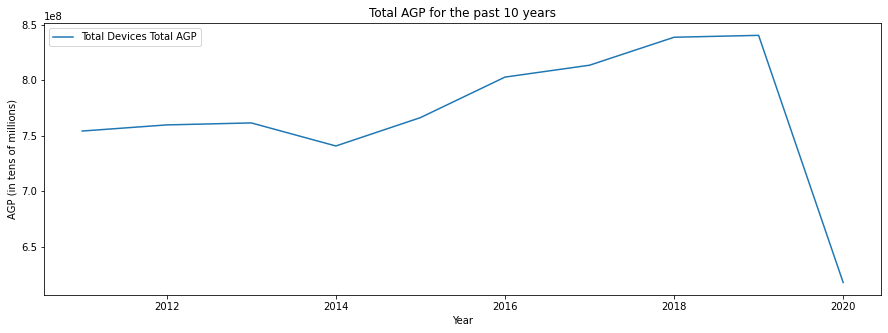

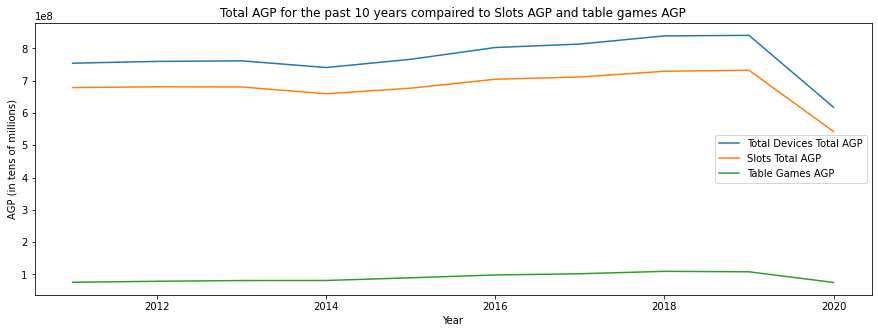

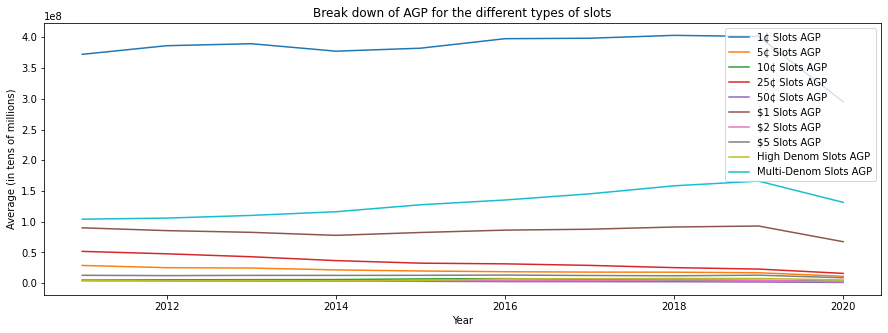

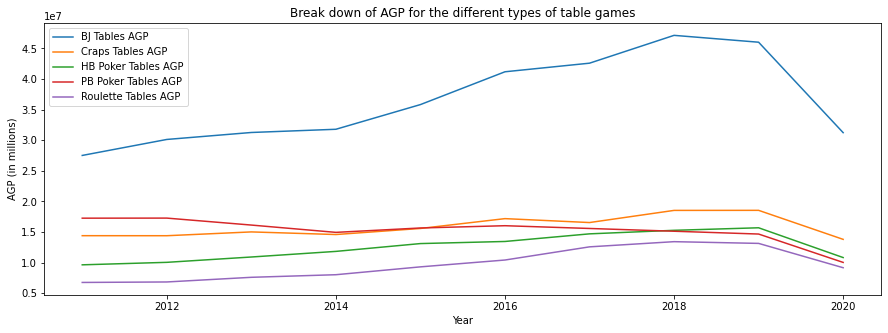

<Figure size 1080x360 with 0 Axes>

In [5]:
#plot 1



state_total= state[state.month.isin(['TOTAL'])]
state_total['year'] = state_total['year'].astype(int)
state_total=state_total[(state_total['year'] < 2021)]
print(state_totals.head(20))

ax = plt.gca()
state_total.plot(kind='line',x='year',y='Total Devices Total AGP',ax=ax)


plt.title("Total AGP for the past 10 years")
plt.xlabel("Year")
plt.ylabel("AGP (in tens of millions)")
plt.show()
plt.savefig('Plot1.png')


#plot 2
ax = plt.gca()

state_total.plot(kind='line',x='year',y='Total Devices Total AGP',ax=ax)
state_total.plot(kind='line',x='year',y='Slots Total AGP',ax=ax)
state_total.plot(kind='line',x='year',y='Table Games AGP',ax=ax)



plt.title("Total AGP for the past 10 years compaired to Slots AGP and table games AGP")
plt.xlabel("Year")
plt.ylabel("AGP (in tens of millions)")
plt.show()
plt.savefig('Plot2.png')

#plot 3
ax = plt.gca()

state_total.plot(kind='line',x='year',y='1¢ Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='5¢ Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='10¢ Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='25¢ Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='50¢ Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='$1 Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='$2 Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='$5 Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='High Denom Slots AGP',ax=ax)
state_total.plot(kind='line',x='year',y='Multi-Denom Slots AGP',ax=ax)
#state.plot(kind='line',x='name',y='num_pets', color='red', ax=ax)

plt.title("Break down of AGP for the different types of slots")
plt.xlabel("Year")
plt.ylabel("Average (in tens of millions)")
plt.show()
plt.savefig('Plot3.png')
#plot 4
ax = plt.gca()

state_total.plot(kind='line',x='year',y='BJ Tables AGP',ax=ax)
state_total.plot(kind='line',x='year',y='Craps Tables AGP',ax=ax)
state_total.plot(kind='line',x='year',y='HB Poker Tables AGP',ax=ax)
state_total.plot(kind='line',x='year',y='PB Poker Tables AGP',ax=ax)
state_total.plot(kind='line',x='year',y='Roulette Tables AGP',ax=ax)
#state.plot(kind='line',x='name',y='num_pets', color='red', ax=ax)

plt.title("Break down of AGP for the different types of table games")
plt.xlabel("Year")
plt.ylabel("AGP (in millions)")
plt.show()
plt.savefig('Plot 4.png')
